In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path 
import SimpleITK as sitk

import matplotlib.pyplot as plt


def save_json(data, file_path):
    with open(file=file_path, mode='w', encoding='utf-8') as f:
        json.dump(data, f)

def load_json(file_path):
    with open(file=file_path, mode='r', encoding='utf-8') as f:
        data = json.load(f)
    return data

%matplotlib inline

In [2]:
from dataset.preprocessing import whitening, normalise_zero_one, normalise_one_one, resize_image_with_crop_or_pad
from dataset.augmentation import flip, add_gaussian_offset, add_gaussian_noise, elastic_transform

In [3]:
dataset_path = Path(os.getcwd()).parent/'dataset_age_regression_V_86'

# Targets

In [4]:
df = pd.read_csv(dataset_path/'targets.csv', index_col=0)
df.head()

,file,target
0,0.npy,59
1,1.npy,59
2,10.npy,86
3,11.npy,86
4,12.npy,86


(array([12.,  4., 20., 11., 12., 18.,  0.,  0.,  3.,  6.]),
 array([23. , 29.3, 35.6, 41.9, 48.2, 54.5, 60.8, 67.1, 73.4, 79.7, 86. ]),
 <BarContainer object of 10 artists>)

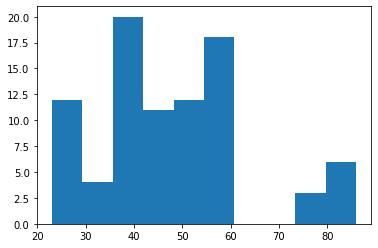

In [5]:
plt.hist(df.target)

In [6]:
df.target.value_counts()

52    12
60    10
43     9
36     8
86     6
59     6
25     6
37     6
29     4
38     4
78     3
30     2
41     2
31     2
45     2
57     2
23     2
Name: target, dtype: int64

# Features

In [7]:
files = [str(dataset_path/'npys'/f) for f in os.listdir(dataset_path/'npys')]

Check nii shapes

In [8]:
shapes = []
for t1_fn in tqdm(files):
    t1 = np.load(t1_fn)
    shapes.append(t1.shape)

print(set(shapes))

100%|██████████| 86/86 [01:19<00:00,  1.08it/s]

{(250, 512, 512), (251, 512, 512)}


loading nii file

In [9]:
tif_path = str(dataset_path/'npys'/df.file[0])
t1 = np.load(tif_path)

In [10]:
t1.shape

(251, 512, 512)

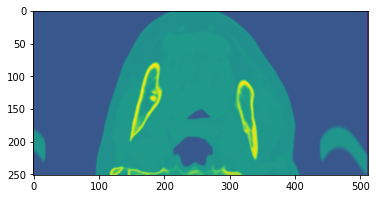

In [11]:
plt.imshow(t1[:, 230, :])

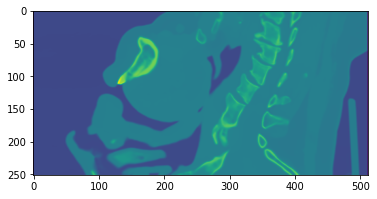

In [12]:
plt.imshow(t1[:, :, 230])

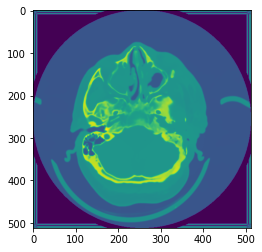

In [13]:
plt.imshow(t1[250, :, :])

In [14]:
# Normalise the image to zero mean/unit std dev using volume statistics:
t1_white = whitening(t1)

# Normalise the image to fit [0, 1] range:
t1_norm_zo = normalise_zero_one(t1)

# Normalise the image to fit [-1, 1] range:
t1_norm_oo = normalise_one_one(t1)

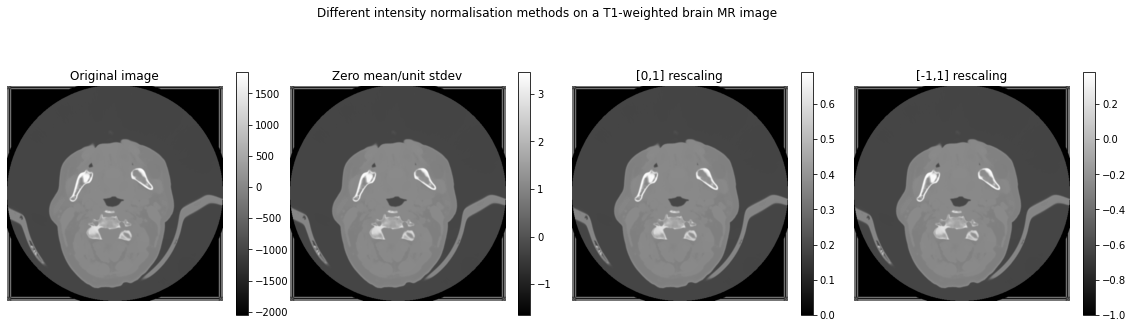

In [15]:
# Visualise using matplotlib.
center_slices = [s//2 for s in t1.shape]

f, axarr = plt.subplots(1, 4, figsize=(20,5));
f.suptitle('Different intensity normalisation methods on a T1-weighted brain MR image')

img = axarr[0].imshow(np.squeeze(t1[center_slices[0], :, :]), cmap='gray');
axarr[0].axis('off')
axarr[0].set_title('Original image')
f.colorbar(img, ax=axarr[0])

img = axarr[1].imshow(np.squeeze(t1_white[center_slices[0], :, :]), cmap='gray');
axarr[1].axis('off')
axarr[1].set_title('Zero mean/unit stdev')
f.colorbar(img, ax=axarr[1])

img = axarr[2].imshow(np.squeeze(t1_norm_zo[center_slices[0], :, :]), cmap='gray');
axarr[2].axis('off')
axarr[2].set_title('[0,1] rescaling')
f.colorbar(img, ax=axarr[2])

img = axarr[3].imshow(np.squeeze(t1_norm_oo[center_slices[0], :, :]), cmap='gray');
axarr[3].axis('off')
axarr[3].set_title('[-1,1] rescaling')
f.colorbar(img, ax=axarr[3])
    
f.subplots_adjust(wspace=0.05, hspace=0, top=0.8)
plt.show(); 

/media/dmitriy/main/data/DICOM_age_regression/resnet_3d/dataset/preprocessing.py:87: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad(image[slicer], to_padding, **kwargs)


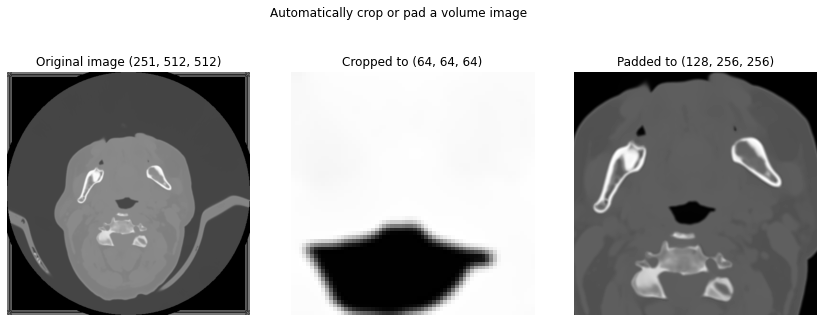

In [16]:
# Crop to [64, 64, 64]
t1_cropped = resize_image_with_crop_or_pad(t1, [64, 64, 64], mode='symmetric')

# Resizing image to [128, 256, 256] required padding
t1_padded = resize_image_with_crop_or_pad(t1, [128, 256, 256], mode='symmetric')

# Visualise using matplotlib.
f, axarr = plt.subplots(1, 3, figsize=(15,5));
f.suptitle('Automatically crop or pad a volume image')

axarr[0].imshow(np.squeeze(t1[t1.shape[0]//2, :, :]), cmap='gray');
axarr[0].axis('off')
axarr[0].set_title('Original image {}'.format(t1.shape))

axarr[1].imshow(np.squeeze(t1_cropped[t1_cropped.shape[0]//2, :, :]), cmap='gray');
axarr[1].axis('off')
axarr[1].set_title('Cropped to {}'.format(t1_cropped.shape))

axarr[2].imshow(np.squeeze(t1_padded[t1_padded.shape[0]//2, :, :]), cmap='gray');
axarr[2].axis('off')
axarr[2].set_title('Padded to {}'.format(t1_padded.shape))
    
f.subplots_adjust(wspace=0.05, hspace=0, top=0.8)
plt.show(); 

In [17]:
# For demo purposes, extract a 2D slice from the image volume. This is just to better
# demonstrate the Gaussian offset augmentation. To demonstrate, that this works on 
# volumes, we ensure that the slice is a 3D volume: 
center_slices = [s//2 for s in t1.shape]
t1_slice = t1[center_slices[0]:center_slices[0]+1,:,:].copy()
print(t1_slice.shape)

# Add a feature dimension and normalise
t1_norm = np.expand_dims(normalise_one_one(t1_slice), axis=-1)

# Randomly flip the image along axis 1
t1_flipped = flip(t1_norm.copy(), axis=1)

# Add a Gaussian offset (independently for each channel)
t1_offset = add_gaussian_offset(t1_norm.copy(), sigma=0.5)

# Add Gaussian noise
t1_noise = add_gaussian_noise(t1_norm.copy(), sigma=0.25)

# Elastic transforms according to:
# [1] Simard, Steinkraus and Platt, "Best Practices for Convolutional
#     Neural Networks applied to Visual Document Analysis", in Proc. of the
#     International Conference on Document Analysis and Recognition, 2003.
t1_trans_low_s = elastic_transform(t1_norm.copy(), alpha=[1, 1e5, 1e5], sigma=[1, 10, 10])
t1_trans_high_s = elastic_transform(t1_norm.copy(), alpha=[10, 2e6, 2e6], sigma=[1, 25, 25])

(1, 512, 512)


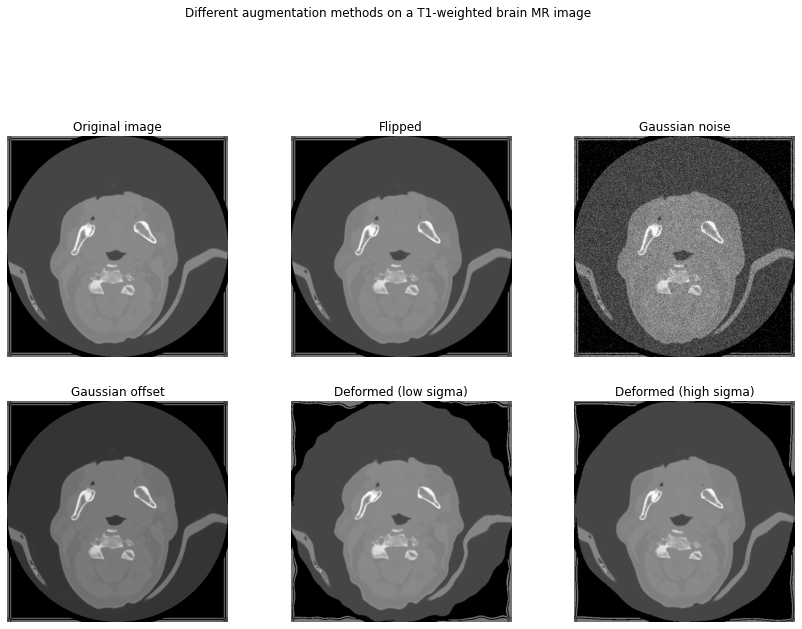

In [18]:
# Visualise using matplotlib
f, axarr = plt.subplots(2, 3, figsize=(15,10));
f.suptitle('Different augmentation methods on a T1-weighted brain MR image')

axarr[0,0].imshow(np.squeeze(t1_norm), cmap='gray', vmin=-1, vmax=1);
axarr[0,0].axis('off')
axarr[0,0].set_title('Original image')

axarr[0,1].imshow(np.squeeze(t1_flipped), cmap='gray', vmin=-1, vmax=1);
axarr[0,1].axis('off')
axarr[0,1].set_title('Flipped')

axarr[0,2].imshow(np.squeeze(t1_noise), cmap='gray', vmin=-1, vmax=1);
axarr[0,2].axis('off')
axarr[0,2].set_title('Gaussian noise')

axarr[1,0].imshow(np.squeeze(t1_offset), cmap='gray', vmin=-1, vmax=1);
axarr[1,0].axis('off')
axarr[1,0].set_title('Gaussian offset')

axarr[1,1].imshow(np.squeeze(t1_trans_low_s), cmap='gray', vmin=-1, vmax=1);
axarr[1,1].axis('off')
axarr[1,1].set_title('Deformed (low sigma)')

axarr[1,2].imshow(np.squeeze(t1_trans_high_s), cmap='gray', vmin=-1, vmax=1);
axarr[1,2].axis('off')
axarr[1,2].set_title('Deformed (high sigma)')
    
f.subplots_adjust(wspace=0.05, top=0.8)
plt.show(); 

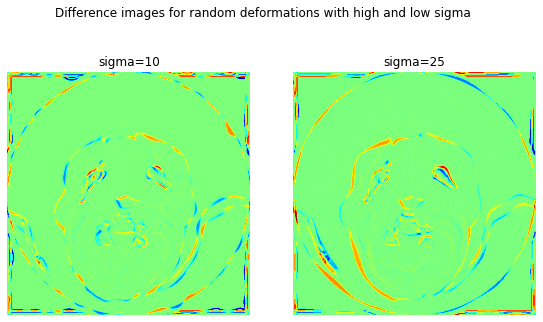

In [19]:
f, axarr = plt.subplots(1, 2, figsize=(10,5));
f.suptitle('Difference images for random deformations with high and low sigma')

axarr[0].imshow(np.squeeze(t1_norm-t1_trans_low_s), cmap='jet');
axarr[0].axis('off')
axarr[0].set_title('sigma=10')

axarr[1].imshow(np.squeeze(t1_norm-t1_trans_high_s), cmap='jet');
axarr[1].axis('off')
axarr[1].set_title('sigma=25')

f.subplots_adjust(wspace=0.05, top=0.8)
plt.show();